#### 1.- Implementación de una estrategia sencilla y backtest

##### 1.1.- Importación de las librerias

In [5]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from ib_insync import *
util.startLoop()

##### 1.2.- Estableciendo conexión con la API TWS de Interactive Brokers

IMPORTANTE: antes de establecer la conexión hay que bajar el software [Trader Workstation (TWS)](https://www.ibkrguides.com/traderworkstation/getting-started.htm) de Interactive Brokers, configurarlo correctamente y tenerlo corriendo. Para ello hay que seguir el [manual](../../0.%20Instalación%20de%20Anaconda%20y%20la%20TWS.pdf).

In [7]:
# Crea un objeto IB
ib = IB()
# se conecta a IB
ib.connect('127.0.0.1', 7497, clientId = 11)
# La API de InteractiveBrokers permite conectarse a una instancia de la TWS (Trader WorkStation) 
# o IB Gateway usando hasta 32 clients.
# Puertos: Paper Trading 7497 | Live trading 7496.

<IB connected to 127.0.0.1:7497 clientId=11>

##### 1.2.- Solicitud de datos historicos

In [8]:
# Parámetros del activo
Contract = Forex('EURUSD')
Compresion = '1 min' # Formato válidos: '1 min', '2 mins'. Formatos inválidos '1 mins','5 min'. Respetar los espacios.

# La función reqHistoricalData() nos permite solicictar datos históricos.
bars = ib.reqHistoricalData(
    Contract,
    endDateTime='',
    durationStr='10 D',
    barSizeSetting=Compresion,
    whatToShow='BID_ASK',
    useRTH=True,
    formatDate=1)

# Almacena los datos históricos en un DataFrame
df = util.df(bars)
# Renombra las columnas
df.rename(columns = {'date':'Time','open':'Open','high':'High','low':'Low','close':'Close'}, inplace = True)
# Asigna el índice 
df.set_index('Time', inplace=True)
# Nos quedamos solo con las columnas Open, High, Low y Close
df = df[['Open','High','Low','Close']]

print('*'*55)
print('Primeras 5 filas de nuestro DataFrame')
print('*'*55)
print(df.head())
print('*'*55)

print('Últimas 5 filas de nuestro DataFrame')
print('*'*55)
print(df.tail())

*******************************************************
Primeras 5 filas de nuestro DataFrame
*******************************************************
                              Open     High      Low    Close
Time                                                         
2024-10-30 17:15:00-04:00  1.08586  1.08611  1.08566  1.08596
2024-10-30 17:16:00-04:00  1.08586  1.08599  1.08584  1.08594
2024-10-30 17:17:00-04:00  1.08583  1.08592  1.08580  1.08592
2024-10-30 17:18:00-04:00  1.08583  1.08594  1.08583  1.08592
2024-10-30 17:19:00-04:00  1.08583  1.08595  1.08579  1.08594
*******************************************************
Últimas 5 filas de nuestro DataFrame
*******************************************************
                              Open     High      Low    Close
Time                                                         
2024-11-13 15:28:00-05:00  1.05645  1.05649  1.05641  1.05647
2024-11-13 15:29:00-05:00  1.05646  1.05651  1.05642  1.05648
2024-11-13 15:30:00

Text(0, 0.5, 'Precio')

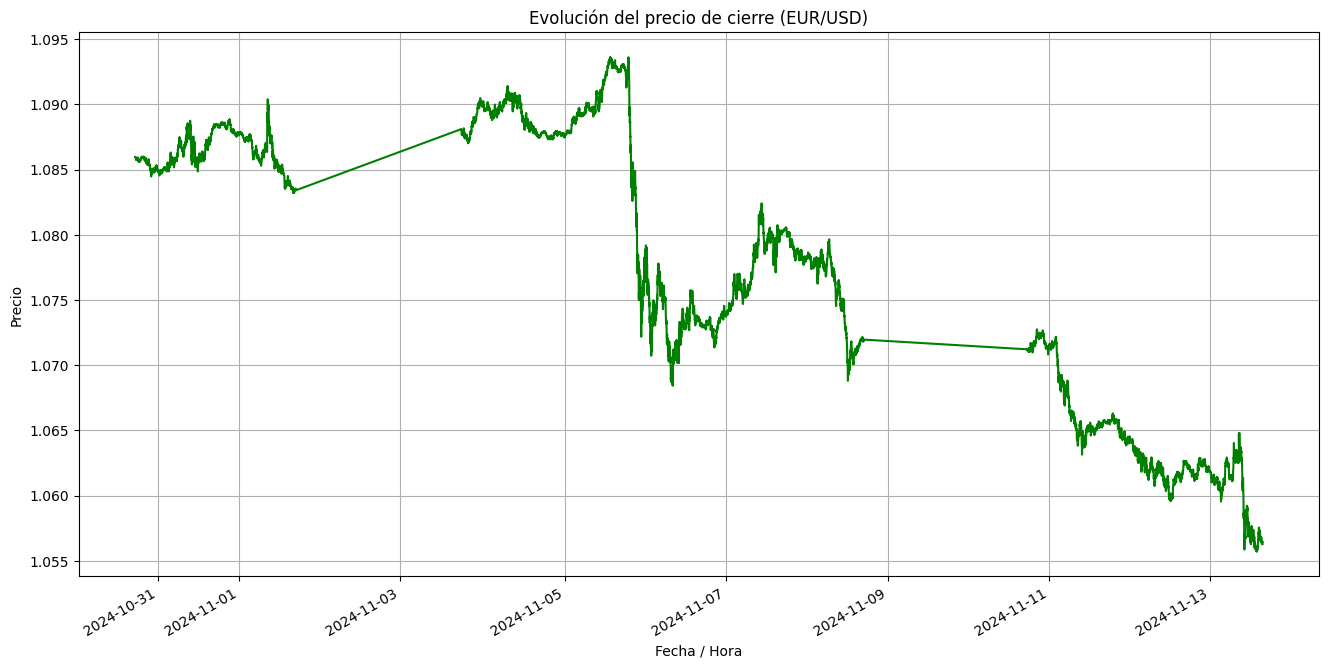

In [9]:
# Crea un gráfico y muesta la evolución del precio de cierre.
df['Close'].plot(grid = True,
                 title ='Evolución del precio de cierre (EUR/USD)',
                 color='green',
                 figsize =(16,8))

# Establece valores para las etiquetas de los ejes X e Y.
plt.xlabel('Fecha / Hora')
plt.ylabel('Precio')

##### 1.4.- Calculo de las SMAs





In [ ]:
df['SMA50'] = ta.sma(df["Close"], length=50)
df['SMA200'] = ta.sma(df["Close"], length=200)

df['EMA50'] = ta.ema(df["Close"], length=50)
df['EMA200'] = ta.ema(df["Close"], length=200)
